# 1. Data Pre-processing

In [64]:
# Importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.utils import shuffle
import seaborn as sns

In [7]:
# Dataset directory path
directory_path = "./dataset"

# List all files in the directory
file_list = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, file))]
print(file_list)  # Shows list of file names

['./dataset\\ICMP.csv', './dataset\\ICMP_FLOOD.csv', './dataset\\SDN_DDOS_dataset.csv', './dataset\\SYN.csv', './dataset\\SYN_FLOOD.csv', './dataset\\udp.csv', './dataset\\UDP_FLOOD.csv']


In [45]:

# Define the desired columns
required_columns = [
    'time', 'switch_id', 'gfe', 'g_usip', 'rfip', 'disp_pakt', 'disp_byte',
    'mean_pkt', 'mean_byte', 'gsp', 'avg_durat', 'avg_flow_dst',
    'rate_pkt_in', 'disp_interval', 'label'
]

# Load all CSVs
dfs = [pd.read_csv(file, low_memory=False) for file in file_list]

# Normalize columns
dfs = [df.rename(columns=lambda x: x.strip().lower()) for df in dfs]

cleaned_dfs = []

for df in dfs:
    # Add any missing columns with default values
    for col in required_columns:
        if col not in df.columns:
            if col == 'label':
                df[col] = -1  # Default label if missing
            elif col == 'time':
                df[col] = pd.NaT
            else:
                df[col] = 0  # Default value for other numeric fields

    # Reorder columns to match required structure
    df = df[required_columns]

    # Convert time
    df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y, %H:%M:%S', errors='coerce')

    # Drop rows with NaNs
    df = df.dropna()

    # Cast types
    df = df.astype({
        'switch_id': 'int64',
        'gfe': 'int64',
        'g_usip': 'int64',
        'rfip': 'float64',
        'disp_pakt': 'float64',
        'disp_byte': 'float64',
        'mean_pkt': 'float64',
        'mean_byte': 'float64',
        'gsp': 'int64',
        'avg_durat': 'float64',
        'avg_flow_dst': 'int64',
        'rate_pkt_in': 'float64',
        'disp_interval': 'float64',
        'label': 'int64'
    })

    cleaned_dfs.append(df)

# Concatenate and shuffle
combined_df = pd.concat(cleaned_dfs, ignore_index=True)
shuffled_df = shuffle(combined_df).reset_index(drop=True)

# Final check
print(shuffled_df['label'].value_counts())
shuffled_df.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_14836\4092078976.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y, %H:%M:%S', errors='coerce')


label
2    82289
0    18457
5    18352
3    14603
4    12170
1     9866
6     8841
Name: count, dtype: int64


,time,switch_id,gfe,g_usip,rfip,disp_pakt,disp_byte,mean_pkt,mean_byte,gsp,avg_durat,avg_flow_dst,rate_pkt_in,disp_interval,label
0,2023-02-21 08:08:38,2,0,0,1.000000,2.683282,2.629616e+02,3.00,294.0,0,3.960000e+17,6,367.666667,1.620000e+17,0
1,2023-02-21 06:31:50,3,0,0,1.000000,23.851974,1.104434e+06,420.75,912497.5,0,4.790000e+17,4,191.333333,7.380000e+16,2
2,2022-11-15 08:02:37,15,1,0,0.333333,0.000000,0.000000e+00,0.00,0.0,1,3.960000e+17,5,26758.200000,3.430000e+17,3
3,2022-11-15 07:24:03,15,0,0,0.500000,22.978251,3.474311e+04,14.00,21168.0,0,6.690000e+17,4,11780.400000,1.010000e+17,0
4,2023-02-03 22:10:58,1,157,157,0.000000,0.000000,0.000000e+00,0.00,0.0,157,4.720000e+17,28232,9652.333333,1.480000e+16,2


In [46]:
 # Specify the folder name for the cleaned dataset
cleaned_folder = "./cleaned_dataset"

# Create the folder if it doesn't exist
if not os.path.exists(cleaned_folder):
    os.makedirs(cleaned_folder)  # Create the folder

# Save the shuffled DataFrame into the cleaned_dataset folder
shuffled_df.to_csv(os.path.join(cleaned_folder, 'shuffled_data.csv'), index=False)

print("Cleaned dataset saved in the folder 'cleaned_dataset' as 'shuffled_data.csv'.")

Cleaned dataset saved in the folder 'cleaned_dataset' as 'shuffled_data.csv'.


# 2. Feature Engineering

In [52]:
def feature_engineering(df):
    """
    Perform feature engineering on the given DataFrame.

    This function generates new features based on existing ones to enhance the 
    predictive power of machine learning models. The following types of features 
    are created:
    
    1. Time-based Features:
        - hour: Hour of the day from 'time' column
        - weekday: Day of the week (0 = Monday, 6 = Sunday)
        - month: Month of the year
        - is_weekend: 1 if the day is Saturday or Sunday, else 0

    2. Interaction Features:
        - pkt_byte_ratio: Ratio of mean packets to mean bytes
        - duration_per_packet: Ratio of average duration to number of packets
        - rate_per_byte: Ratio of rate of incoming packets to bytes

    3. Log-Transformed Features (to reduce skewness):
        - log_disp_byte: Log-transformed dispersed bytes
        - log_disp_pakt: Log-transformed dispersed packets
        - log_avg_durat: Log-transformed average duration

    4. Outlier Indicator:
        - is_high_pkt_rate: Flag (1/0) if 'rate_pkt_in' is above 95th percentile

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the traffic dataset with columns like 'time', 
        'mean_pkt', 'mean_byte', 'avg_durat', 'disp_pakt', 'disp_byte', 'rate_pkt_in'.

    Returns:
    --------
    pd.DataFrame
        Modified DataFrame with new engineered features added.
    """
    
    # Ensure 'time' is in datetime format
    df['time'] = pd.to_datetime(df['time'], errors='coerce')

    # Drop rows where 'time' couldn't be parsed
    df = df.dropna(subset=['time'])
    
    # Time-based features
    df['hour'] = df['time'].dt.hour
    df['weekday'] = df['time'].dt.weekday
    df['month'] = df['time'].dt.month
    df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

    # Interaction features
    df['pkt_byte_ratio'] = df['mean_pkt'] / (df['mean_byte'] + 1e-5)
    df['duration_per_packet'] = df['avg_durat'] / (df['disp_pakt'] + 1e-5)
    df['rate_per_byte'] = df['rate_pkt_in'] / (df['disp_byte'] + 1e-5)

    # Log transformations
    df['log_disp_byte'] = np.log1p(df['disp_byte'])
    df['log_disp_pakt'] = np.log1p(df['disp_pakt'])
    df['log_avg_durat'] = np.log1p(df['avg_durat'])

    # Outlier flag
    threshold = df['rate_pkt_in'].quantile(0.95)
    df['is_high_pkt_rate'] = (df['rate_pkt_in'] > threshold).astype(int)

    return df

In [54]:
# Specify the folder name for the cleaned dataset
cleaned_folder = "./cleaned_dataset"
balanced_df = pd.read_csv(os.path.join(cleaned_folder, 'shuffled_data.csv'))
balanced_df.head()

,time,switch_id,gfe,g_usip,rfip,disp_pakt,disp_byte,mean_pkt,mean_byte,gsp,avg_durat,avg_flow_dst,rate_pkt_in,disp_interval,label
0,2023-02-21 08:08:38,2,0,0,1.000000,2.683282,2.629616e+02,3.00,294.0,0,3.960000e+17,6,367.666667,1.620000e+17,0
1,2023-02-21 06:31:50,3,0,0,1.000000,23.851974,1.104434e+06,420.75,912497.5,0,4.790000e+17,4,191.333333,7.380000e+16,2
2,2022-11-15 08:02:37,15,1,0,0.333333,0.000000,0.000000e+00,0.00,0.0,1,3.960000e+17,5,26758.200000,3.430000e+17,3
3,2022-11-15 07:24:03,15,0,0,0.500000,22.978251,3.474311e+04,14.00,21168.0,0,6.690000e+17,4,11780.400000,1.010000e+17,0
4,2023-02-03 22:10:58,1,157,157,0.000000,0.000000,0.000000e+00,0.00,0.0,157,4.720000e+17,28232,9652.333333,1.480000e+16,2


In [55]:
featured_df = feature_engineering(balanced_df)
featured_df.head()

,time,switch_id,gfe,g_usip,rfip,disp_pakt,disp_byte,mean_pkt,mean_byte,gsp,...,weekday,month,is_weekend,pkt_byte_ratio,duration_per_packet,rate_per_byte,log_disp_byte,log_disp_pakt,log_avg_durat,is_high_pkt_rate
0,2023-02-21 08:08:38,2,0,0,1.000000,2.683282,2.629616e+02,3.00,294.0,0,...,1,2,0,0.010204,1.475799e+17,1.398176e+00,5.575804,1.303804,40.520191,0
1,2023-02-21 06:31:50,3,0,0,1.000000,23.851974,1.104434e+06,420.75,912497.5,0,...,1,2,0,0.000461,2.008219e+16,1.732411e-04,13.914845,3.212937,40.710477,0
2,2022-11-15 08:02:37,15,1,0,0.333333,0.000000,0.000000e+00,0.00,0.0,1,...,1,11,0,0.000000,3.960000e+22,2.675820e+09,0.000000,0.000000,40.520191,1
3,2022-11-15 07:24:03,15,0,0,0.500000,22.978251,3.474311e+04,14.00,21168.0,0,...,1,11,0,0.000661,2.911448e+16,3.390715e-01,10.455765,3.177147,41.044560,0
4,2023-02-03 22:10:58,1,157,157,0.000000,0.000000,0.000000e+00,0.00,0.0,157,...,4,2,0,0.000000,4.720000e+22,9.652333e+08,0.000000,0.000000,40.695755,0


# 3. Machine learning model

In [56]:
X = featured_df.drop(columns=['label', 'time'])  # drop label & raw time if not used
y = featured_df['label']

In [58]:
from sklearn.model_selection import train_test_split

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the result
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training target shape:", y_train.shape)
print("Testing target shape:", y_test.shape)

Training features shape: (131662, 24)
Testing features shape: (32916, 24)
Training target shape: (131662,)
Testing target shape: (32916,)


In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluation metrics
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Feature importance
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

report, conf_matrix, accuracy, importances.head(10)

({'0': {'precision': 0.10036141228801779,
   'recall': 0.09788503253796095,
   'f1-score': 0.09910775566231983,
   'support': 3688.0},
  '1': {'precision': 0.09791983764586504,
   'recall': 0.09796954314720813,
   'f1-score': 0.0979446840903324,
   'support': 1970.0},
  '2': {'precision': 0.10902097481819821,
   'recall': 0.11064348886855749,
   'f1-score': 0.10982623963189442,
   'support': 16395.0},
  '3': {'precision': 0.13925362819626813,
   'recall': 0.13628677713899223,
   'f1-score': 0.13775423004614595,
   'support': 2957.0},
  '4': {'precision': 0.09316517493897478,
   'recall': 0.09443298969072166,
   'f1-score': 0.09379479827974606,
   'support': 2425.0},
  '5': {'precision': 0.10040595399188092,
   'recall': 0.10092491838955386,
   'f1-score': 0.100664767331434,
   'support': 3676.0},
  '6': {'precision': 0.08363417569193743,
   'recall': 0.07700831024930747,
   'f1-score': 0.0801845976348428,
   'support': 1805.0},
  'accuracy': 0.1066350710900474,
  'macro avg': {'precisi

C:\Users\hp\AppData\Local\Temp\ipykernel_14836\2289218653.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cm.show()
C:\Users\hp\AppData\Local\Temp\ipykernel_14836\2289218653.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_fi.show()


Plots saved in the 'results' folder as:
1. ./results\confusion_matrix.png
2. ./results\feature_importance.png


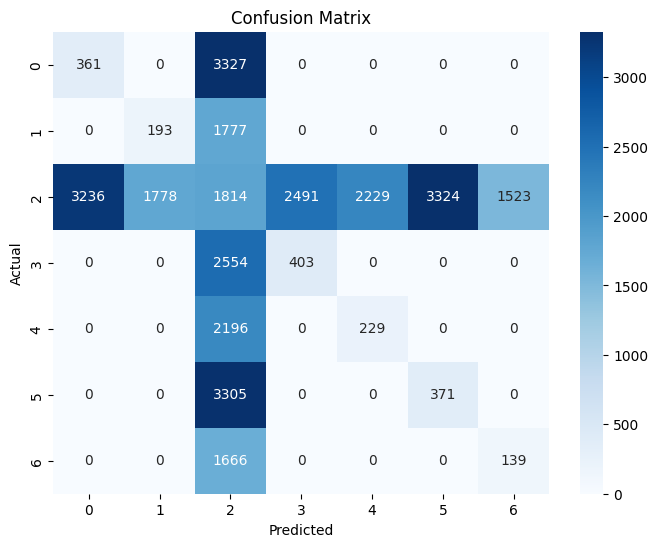

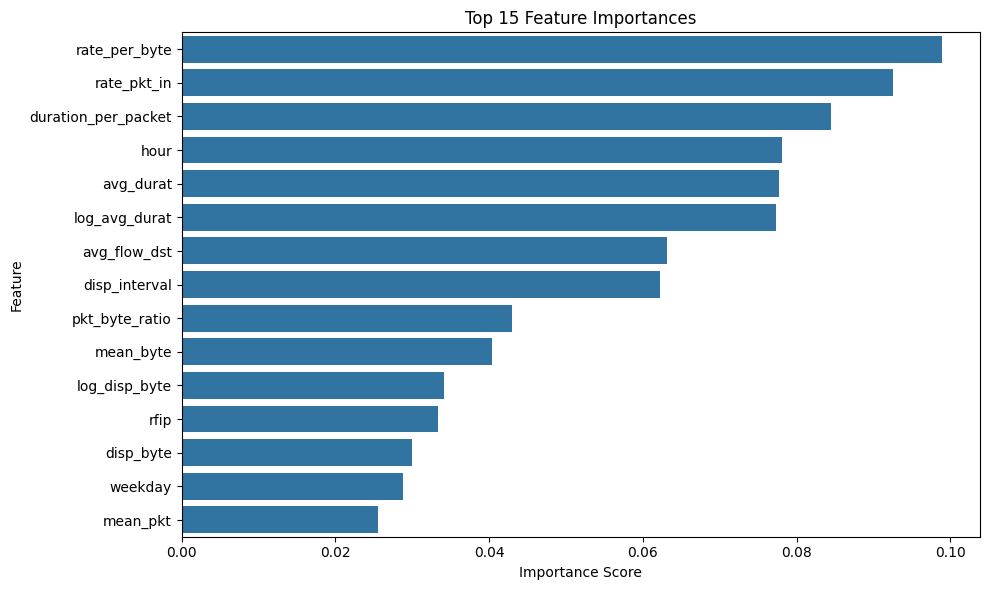

In [66]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, ax=ax_cm)
ax_cm.set_xlabel("Predicted")
ax_cm.set_ylabel("Actual")
ax_cm.set_title("Confusion Matrix")

# Feature Importance
importances = rf_model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({"Feature": features, "Importance": importances})
feature_df = feature_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
fig_fi, ax_fi = plt.subplots(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_df.head(15), ax=ax_fi)
ax_fi.set_title("Top 15 Feature Importances")
ax_fi.set_xlabel("Importance Score")
ax_fi.set_ylabel("Feature")

plt.tight_layout()

# Create the results folder if it doesn't exist
results_folder = "./results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Save the confusion matrix plot
confusion_matrix_path = os.path.join(results_folder, "confusion_matrix.png")
fig_cm.savefig(confusion_matrix_path)

# Save the feature importance plot
feature_importance_path = os.path.join(results_folder, "feature_importance.png")
fig_fi.savefig(feature_importance_path)

# Show the plots
fig_cm.show()
fig_fi.show()

print(f"Plots saved in the 'results' folder as:\n1. {confusion_matrix_path}\n2. {feature_importance_path}")
